# Player 2 Example

In [19]:
%run '../ego.py'
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib
%run '../preprocess.py'
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
sns.set_style('ticks');
sns.set_palette('Set1')
import json

## Best $\Sigma^{-1}$ for EGO

First we insantiate the proprocessing and data objects. This has been done in a way that replicates Scikit-Learn's API. 

If you have the ICA and play data `.pkl` files already, you can reference them in the builder function. Otherwise, uncomment the three lines that will make them for you (will take a long time!). You can, from then on, use the references instead of re-calculating it all the time. 

In [20]:
pre = Preprocess(all_dat='../all_games.pkl', pca_model='../eco_full_pca.pkl')

# pre = Preprocess()
# pre.get_json('alluser_control.json')  # uncomment this to create the pkl file needed!!
# pre.train_pca()

X, y = pre.ready_player_one(2)

# scale = StandardScaler()
scale = MinMaxScaler((-1.,1.))
X = scale.fit_transform(X)

We need to externally reference the second-best player's data for our reference here, so let's make a mask and extract score info. 

In [21]:
top6 = [78, 122, 166, 70, 67, 69] #best players
m1, m2, m3, m4, m5, m6 = [pre.full_tab.userid.values==i for i in top6]
masks = [m1, m2, m3, m4, m5, m6]
p1=pre.all_dat[masks[0]]
p1_score=pre.full_tab["rem_nrg"].values[masks[0]]

Now we can load the sigma that has been previously solved for (using SLSQP, initialized on the range [0,2] with steps of 0.1. Note that there are only two components that seem to have any bearing on how closely the Bayesian Regressor matches the human's strategy. 

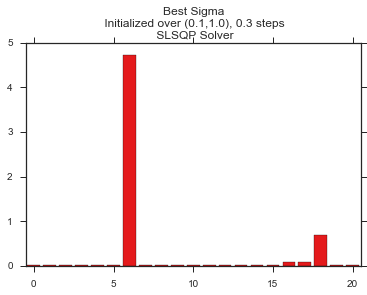

In [22]:
file_address = 'p2_slsqp_sigma.json'
with open(file_address, 'r') as f:
    # pickle.dump([obj_set, sigma_set], f)
    best_obj, best_sig = json.load( f)
f.close()

plt.bar(range(21), best_sig, align='center', log=False)
plt.xlim(-.5,20.5);
plt.title('Best Sigma\n Initialized over (0.1,1.0), 0.3 steps\n SLSQP Solver')

Now let's see what the $R$ matrix looks like for this regressor. 

[0.01000000003747952, 0.010000000040028854, 0.010000000145809037, 0.01000000004156303, 0.01000000004185919, 0.010000000136693457, 4.729621709389694, 0.010000000125259504, 0.010000000012316147, 0.010000000198289434, 0.010000000017400326, 0.010000000059970524, 0.010000000111597466, 0.010000000061960697, 0.010000000140276242, 0.01000000005367525, 0.08504143771268459, 0.07557501673624753, 0.6802524111561808, 0.010000000020229065, 0.01000000003481802]


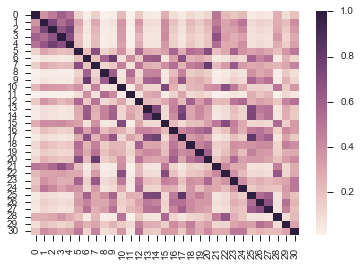

In [23]:
unit_sig = np.ones(21)

bestKrig = Kriging(best_sig)
bestKrig.fit(X,y)

print best_sig
sns.heatmap(bestKrig.R)

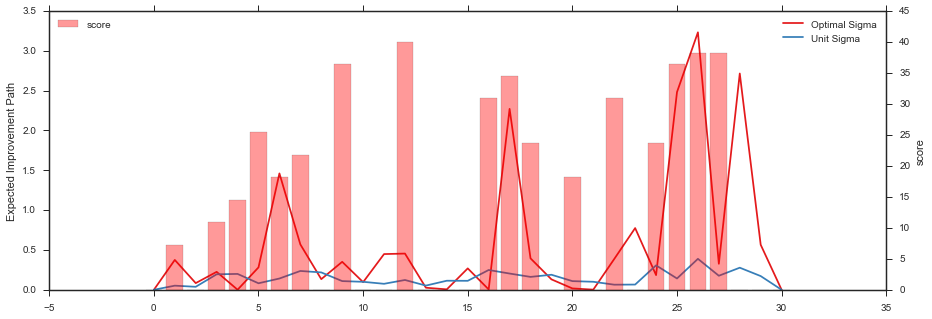

In [24]:
fig, host = plt.subplots(figsize=(15,5))

#host.plot(np.diag(visI))
z_sig = np.zeros(31)
z_sig[-1]=2.6
ax2 = host.twinx()
best_path = bestKrig.f_path(best_sig)
unit_path = bestKrig.f_path(unit_sig)
# zero_path = bestKrig.f_path(z_sig)
host.plot(best_path, label='Optimal Sigma')
host.plot(unit_path, label='Unit Sigma')
# host.semilogy(zero_path+1, label='Zero Sigma')
host.set_ylabel('Expected Improvement Path')
ax2.bar(range(bestKrig.n), y, align='center', log=False, 
        color='r', alpha=0.4, label='score')
ax2.set_ylabel('score')
# plt.ylim(0,20)
# bestKrig.f_path(best_sig)

# best_diff = [(best_path)[i] - (best_path)[i-1] for i in range(1,32)]
# unit_diff = [(unit_path)[i] - (unit_path)[i-1] for i in range(1,32)]
# host.plot(best_diff-np.min(best_diff), label='Optimal Sigma')
# host.plot(unit_diff-np.min(best_diff), label='Unit Sigma')
host.legend()
ax2.legend(loc=2)
# print np.log(np.sum([(unit_path+1)[i] - (unit_path+1)[i-1] for i in range(1,30)]))
# print np.log(np.sum([(best_path+1)[i] - (best_path+1)[i-1] for i in range(1,30)]))
# print bestKrig.obj(best_sig), bestKrig.obj(unit_sig)
# print best_diff-np.min(best_diff)+1

For visualization, we can recreate the EcoRacer Track. A good way to visualize the progression of plays is to view the full signal matrix as white (brakes), black (accelerate), and gray (no input). We can see a lot of info this way. 

In [25]:
data = [0,0,10,20,30,40,50,60,70,80,90,90,90,60,30,0,0,0,0,0,5,10,20,40,60,80,90,90,90,90,70,50,
        30,30,30,30,30,10,10,10,40,70,70,70,90,90,90,70,50,30,10,0,0,0,40,80,80,80,80,70,60,50,40,30,20,
        10,0,0,10,20,30,40,50,60,70,80,80,80,70,60,50,40,40,40,60,80,80,80,60,40,20,0,0,0,0,0]

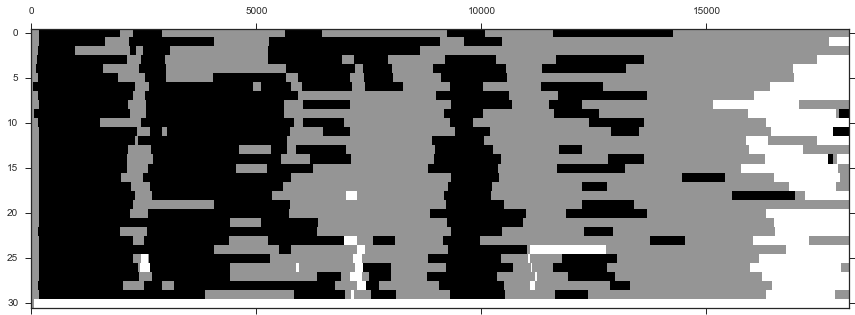

In [26]:
p2=pre.all_dat[masks[1]]
plt.figure(figsize=(15,5))
plt.matshow(p2, aspect=200, fignum=False)

Finally, let's combine all of what we have so far. The below figure shows all of the human plays in chronological order, the independent components that were deemed 'important' in the $\Sigma^{-1}$ of the Bayesian Regressor, the scores of each play (blue bars), and the track itself (in red).

In [27]:
def comp_play(comps):
    sns.set_style('ticks')
    fig, host = plt.subplots(figsize=(15,5))

    #host.plot(np.diag(visI))

    ax2 = host.twinx()
    ax1 = host.twinx()
    ax1.matshow(p2, aspect=150, alpha=.5)
    ax2.plot(np.linspace(0,18120,num=96), data, color='r')
    ax2.set_ylim(0,1000)
    host.set_xlim(0,18160)
    host.set_ylabel("Importance Metric")
    ax1.spines["right"].set_position(("axes", 1.1))
    ax1.set_ylabel("Play Number")
    ax2.set_yticks([0., 50., 100.]);
    ax2.set_ylabel("Score")
    ax1.barh(range(bestKrig.n), -20*y, align='center', 
             left = 18120+1812, clip_on=False)
    #host.plot(1/(np.diag(visI)+.0001))
    # host.plot(pre.pca.components_[1])
    for i in comps:
        host.plot(pre.pca.components_[i])

First, the two very important components:

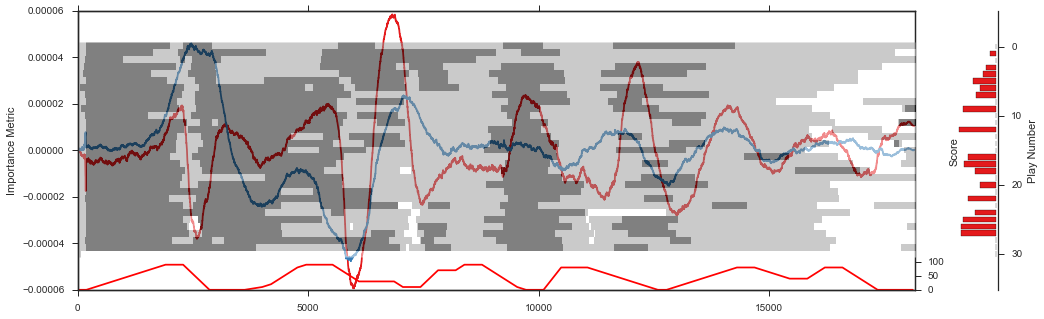

In [30]:
comp_play([6,18])
#         host.plot(pre.pca.components_[24])
    # host.plot(pre.pca.components_[28])

Next, the other, non-minimal components:

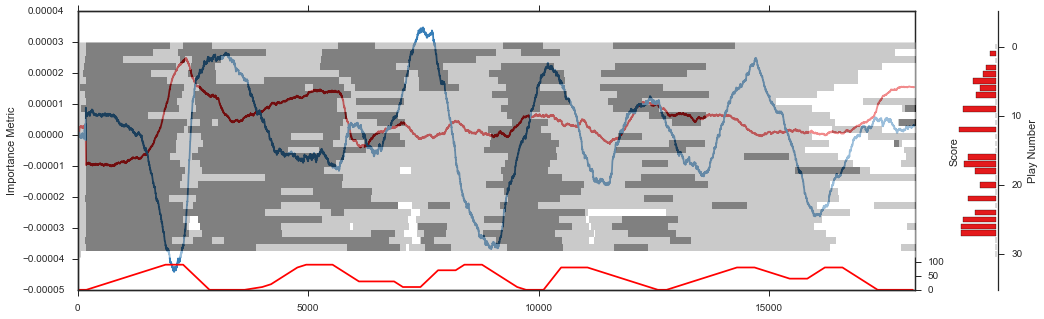

In [31]:
comp_play([17,16])

Note that the two components are, for the large part of the track, out of phase. These two together would cover most of the track features. Interestingly, No 'endgame' behavior, like the breaking that arises fairly early on in this guy's strategy, is captured. Most of the updates seem to be focused on the late-mid region, where he switches the location of accelerating quite frequently. 

## More on ICA

Say we wanted to check what arbitrary components were? You can pass a list as `which` to plot whatever components you like. 

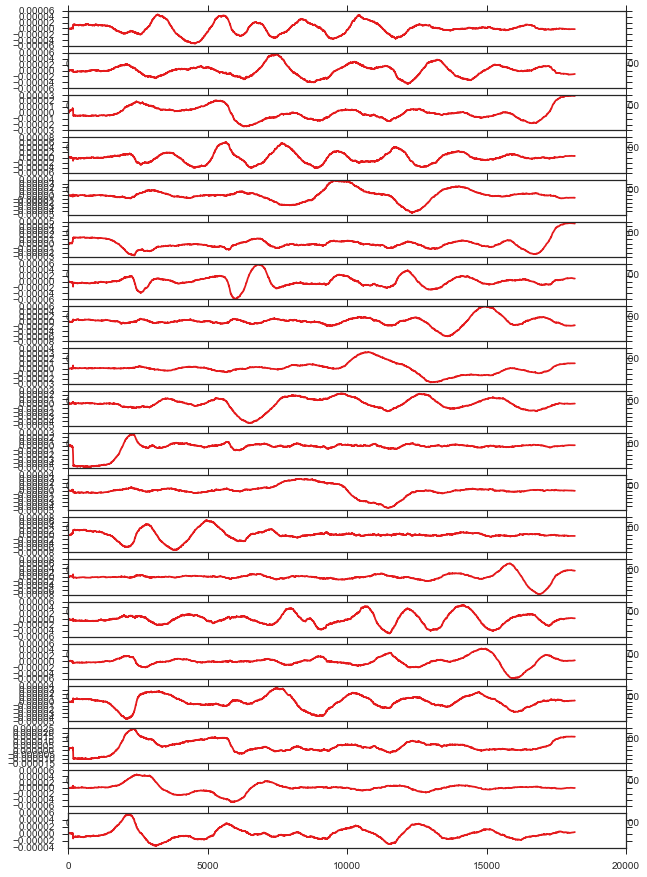

In [34]:
plt.figure(figsize=(10,15))
which = range(20)
for n,i in enumerate(which):
    plt.subplot(len(which),1,n+1)
    plt.plot(pre.pca.components_[i])

Now, what if we want to see how good ICA is doing at re-capturing the original input (driving) signals? The easiest way, but scikit specific, is to use the inverse transform methods on the scaler and then ICA to recreate signals in the set {-1,0,1}. Make sure to ignore the Gear Ratio (last column in X)

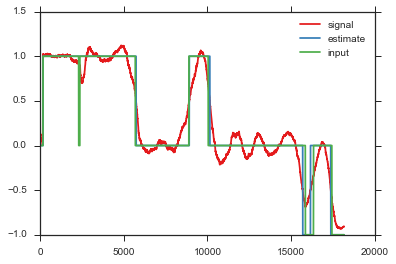

In [35]:
n=12
rounds=np.array([-1., 0., 1.])
x_proj=pre.pca.inverse_transform(scale.inverse_transform(X)[:,:-1])
x_est= np.subtract.outer(x_proj[n], rounds)
y_est = np.argmin(abs(x_est), axis=1)
plt.plot(x_proj[n], label='signal')
plt.plot(rounds[y_est], label='estimate')
plt.plot(pre.all_dat[masks[1]][n], label='input')
plt.legend()

Another way, and one that can use the saved `.json` files in the repo, is to read the docs and re-create the inversion functions manually. As you can see, same result. 

(31L, 18160L)


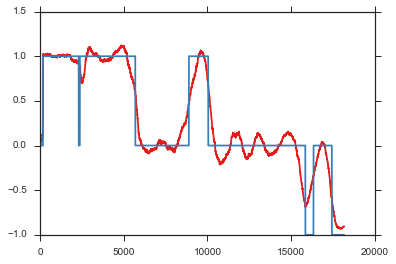

In [36]:
test_x = np.copy(X)
check_x = pre.pca.inverse_transform(scale.inverse_transform(X)[:,:-1])

test_x = (test_x-scale.min_)/scale.scale_ #de-scale it
test_x = np.dot(test_x[:,:-1], pre.pca.mixing_.T)+ pre.pca.mean_ #project back/whiten
plt.plot(test_x[n])

print test_x.shape
plt.plot(pre.all_dat[masks[1]][n])

To check the performance of the thresholder on the external EcoRacer sim, just save a `.txt` containing the 30-dim play that you would like to test

In [38]:
n=0
np.savetxt('mix_scaled_p2_'+str(n)+'.txt', X[n])

In [39]:
bestKrig.obj(best_sig), bestKrig.obj(unit_sig)

(18.25819478481878, 4.4537200671436965)

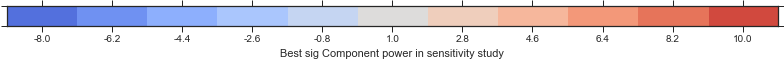

In [40]:
trials = np.linspace(-8, 10, num=11)
sns.palplot(sns.color_palette("coolwarm", 11));
plt.gca().set_xticks(range(11))
# print plt.xticks()
plt.gca().set_xticklabels([str(i) for i in trials])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    pad=2,
    labelbottom='on') # labels along the bottom edge are off
# print [str(i) for i in trials]
plt.xlabel('Best sig Component power in sensitivity study')
plt.tight_layout()
# sns.palplot(sns.diverging_palette(20, 220, n=10, center='dark')

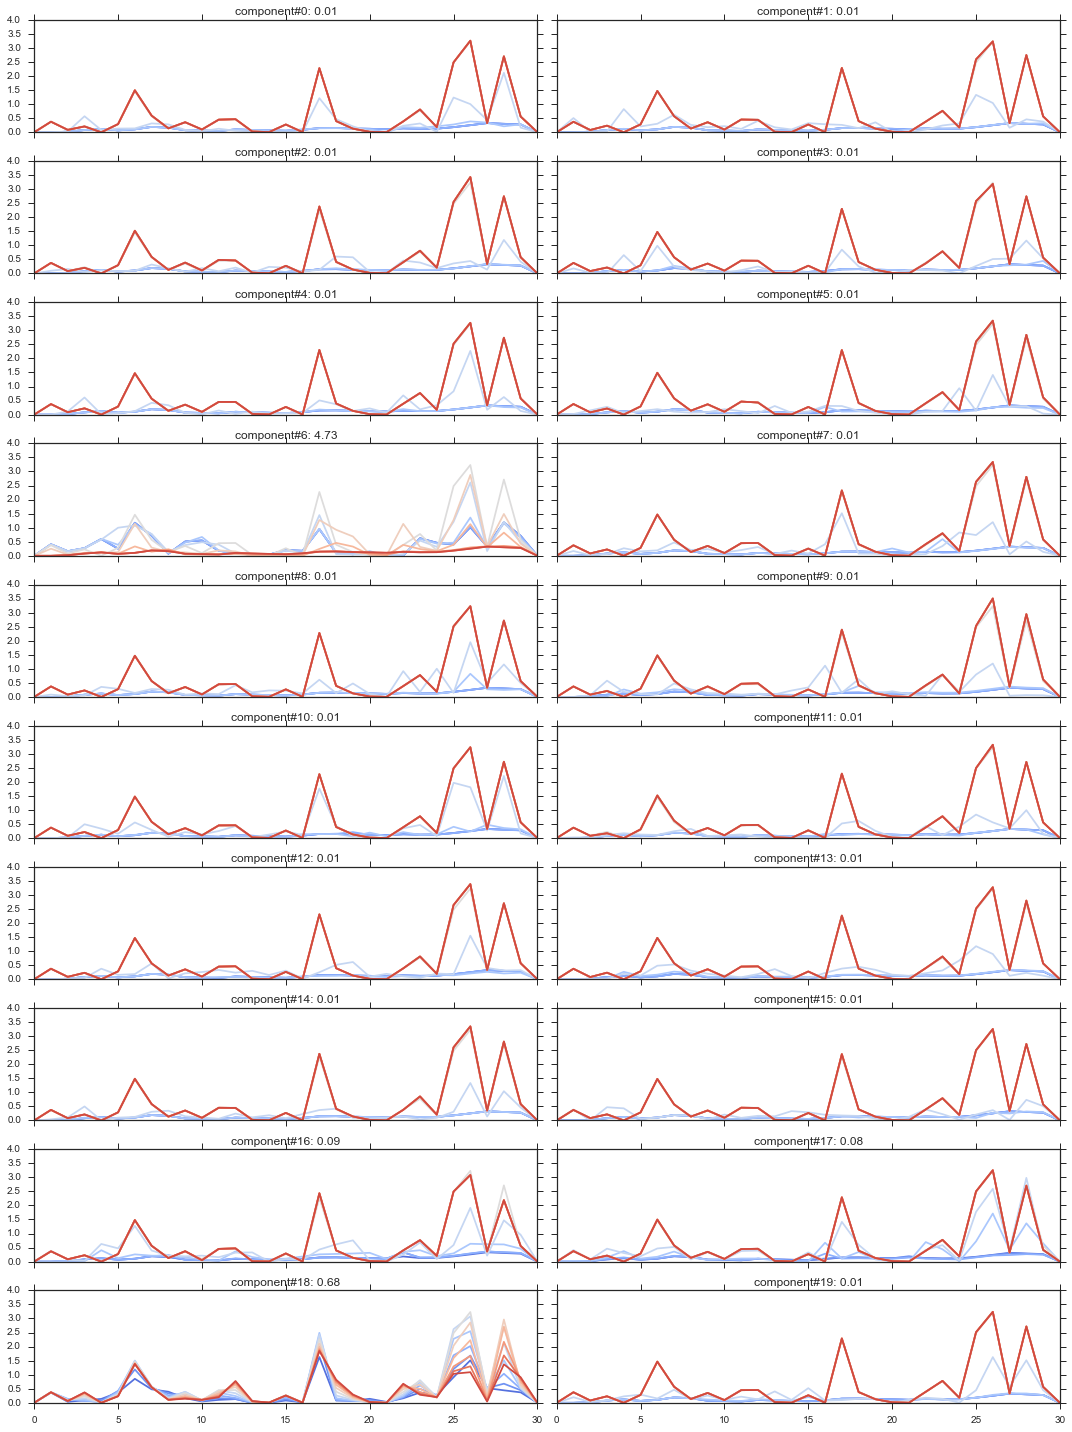

In [42]:

# sns.set_style('darkgrid')
trials = np.linspace(-8, 10, num=11)

# sns.palplot("GnBu_d", len(trials))
# palette = sns.diverging_palette(20, 220, n=len(trials), center="dark")
palette = 'coolwarm'

sns.set_palette(palette, n_colors=len(trials))
fig,ax = plt.subplots(figsize=(15,20), nrows = 10, ncols = 2, sharex=True, sharey=True)
for n,j in enumerate(ax.flatten()):
    for i in trials:
#         print i
        pows = np.ones(21)
        pows[n] = i
        sig = np.power(best_sig, pows)
        lines = j.plot(bestKrig.f_path(sig))
        j.set_title('component#'+str(n)+': '+"{:.2f}".format(best_sig[n]))
plt.tight_layout()
# fig.colorbar(lines, ax=ax.ravel().tolist())

In [25]:
pre.full_tab

,finaldrive,id,keys,ranking_percentage,ranking_scoreboard,score,time,userid,rem_nrg
0,10,1,"{""acc"":[174,2048,2771,3535,4847],""brake"":[]}",0,-1,-1,2014-10-14T22:02:50.915Z,2,0.000000
1,10,2,"{""acc"":[174,2048,2771,3535,4847],""brake"":[]}",0,-1,-1,2014-10-14T22:02:52.481Z,2,0.000000
2,10,3,"{""acc"":[177,2269,3530,4470,6773,13267,13718,14...",0,-1,-1,2014-10-14T22:09:12.254Z,2,0.000000
3,10,4,"{""acc"":[177,1932,3339,5307,5930,6564,11775,126...",0,-1,-1,2014-10-14T22:10:01.759Z,2,0.000000
4,10,5,"{""acc"":[174,3117,3886,5076,5422,6089,6628,7897...",0,-1,1882614,2014-10-14T22:10:35.392Z,2,5.454545
5,10,6,"{""acc"":[161,2176,3200,5879],""brake"":[]}",0,-1,-1,2014-10-15T01:57:24.394Z,1,0.000000
6,10,7,"{""acc"":[176,1529,1635,1892,2027,2309,2934,5799...",100,1,1692599,2014-10-15T13:50:19.563Z,1,14.545455
8,10,9,"{""acc"":[173,1215,1669,2567,3164,3293,3572,4818...",0,-1,-1,2014-10-15T18:12:06.498Z,1,0.000000
9,10,10,"{""acc"":[124,124,444,444],""brake"":[873,873,723,...",0,-1,-1,2014-10-17T15:20:22.918Z,1,0.000000
10,10,11,"{""acc"":[174,174,730,730],""brake"":[]}",0,-1,-1,2014-10-17T15:21:27.682Z,1,0.000000


In [ ]:
import scipy.optimize as opt
all_sigs = np.zeros((len(pre.full_tab['id'].tolist()), 31))
all_improv = np.zeros_like(pre.full_tab['id'].tolist())
lb = 0.01
ub = 100.
bounds = [(lb, ub)]*31

for n,i in enumerate(pre.full_tab['id'].tolist()): 
    
    a,b = pre.prep_by_id(i)
    print i,len(a)
    if len(a)==1 or len(a)==0:
        all_improv[n] = 0
        continue
    krig = Kriging(best_sig)
    krig.fit(a,b)
    x0 = np.ones(31)
    func = lambda x: - krig.f_by_sig(x)
    res = opt.minimize(func, x0=x0, bounds=bounds, method='SLSQP', tol=1e-5,
                               options={'eps': 1e-2, 'iprint': 2, 'disp': True, 'maxiter': 100})
#     all_improv[n] = np.nan_to_num(krig.f(a[-1])[0])
    all_improv[n] = res.fun
    all_sigs[n] = res.x
    print res.fun, res.x
# sns.distplot(all_improv, kde=False, hist_kws={'log':True})

1 1
2 2
  NIT    FC           OBJFUN            GNORM
    1    33    -0.000000E+00     0.000000E+00
Optimization terminated successfully.    (Exit mode 0)
            Current function value: [[-0.]]
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
[[-0.]] [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
3 3
  NIT    FC           OBJFUN            GNORM
    1    33    -0.000000E+00     0.000000E+00
Optimization terminated successfully.    (Exit mode 0)
            Current function value: [-0.]
            Iterations: 1
            Function evaluations: 33
            Gradient evaluations: 1
[-0.] [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
4 4
  NIT    FC           OBJFUN            GNORM
    1    33    -0.000000E+00     0.000000E+00
Optimization terminated successfully.    (Exit

(2250L, 31L)


ValueError: operands could not be broadcast together with shapes (14,) (15,) (14,) 

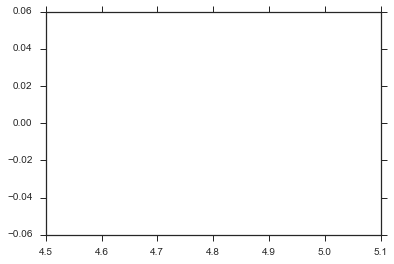

In [150]:
print all_sigs.shape
sns.distplot(all_sigs[:200,30], kde=False, hist_kws={'log':True}, rug=True)

In [63]:

for n,i in enumerate(pre.full_tab['id'].tolist()): 
    
    a,b = pre.prep_by_id(i)
    print i,len(a)
    if len(a)==1 or len(a)==0:
        all_improv[n] = 0
        continue
    krig = Kriging(best_sig)
    krig.fit(a,b)
#     all_improv[n] = np.nan_to_num(krig.f(a[-1])[0])

array([[ 0.,  0.,  0., ...,  1.,  1.,  1.],
       [ 0.,  0.,  0., ...,  1.,  1.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  1.],
       [ 0.,  0.,  0., ...,  1.,  1.,  1.]])

In [107]:
def expect_by_sig(sig_inv):
    x = krig.X[-1]
    old_sig = self.SI[:]
    krig.SI = np.diag(sig_inv)
    krig.fit(krig.X[:-1], krig.y)
    return krig.f
def solve_sig(i):
    X,y = pre.prep_by_id(i)
    X = MinMaxScaler((-1.,1.)).fit_transform(X)
    x0 = np.ones(self.n)
    
    
    krig = Kriging(x0)
#     krig.fit(X[:-1],y[:-1])
#     all_improv[n] = np.nan_to_num(krig.f(X[-1])[0])
    func = lambda x: -np.nan_to_num(krig.f(x)[0])
    
    lb = 0.01
    ub = 100.
    bounds = [(lb, ub)]*self.n
    res = opt.minimize(func, x0=x0, bounds=bounds, method='SLSQP', tol=1e-5,
                               options={'eps': 1e-2, 'iprint': 2, 'disp': True, 'maxiter': 100},
                               callback=self.callbackF)

IndentationError: expected an indented block (<ipython-input-107-3920aec19c2a>, line 4)